In [1]:
import copy
import folium
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import networkx as nx
import numpy as np
import pandas as pd
from os import path
import pickle
from pyproj import Transformer
from timeit import default_timer as timer

# From local files:
from hasgrid import HashGrid
from helpfunctions import get_rnd_graph, plot_Graph, plot_log, path_to_list
from helpfunctions import get_rnd_segment, diff_E, move_segment, get_length, reset
from helpfunctions import count_intersections

# Load "city" locations

In [2]:
# City data from: https://simplemaps.com/data/fi-cities
cities = pd.read_csv(path.join('.','data','fi.csv'), usecols=['city', 'lat', 'lng'])
cities.head(3)

,city,lat,lng
0,Helsinki,60.1756,24.9342
1,Espoo,60.2100,24.6600
2,Tampere,61.4981,23.7608


# Latitude and longitude to Cartesian coodrinates

In [3]:
cities_map = folium.Map()

# Add markers:
for city in cities.itertuples(index=False):
    marker = folium.Marker(location=(city.lat, city.lng), popup=city.city)
    marker.add_to(cities_map)

# Crop the map:
sw = cities[['lat', 'lng']].min().values.tolist()
ne = cities[['lat', 'lng']].max().values.tolist()
cities_map.fit_bounds([sw, ne]) 
    
cities_map

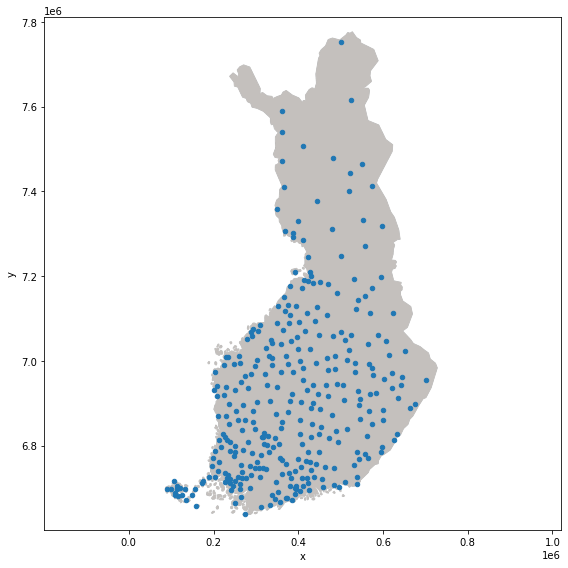

In [4]:
# Roughly recreate the above using flattened coordinates and a siluette of Finland
t = Transformer.from_crs("epsg:4326", "epsg:3067") # From global Geodetic System to Finnish system
cities[['x','y']] = cities.apply(lambda r: t.transform(r['lat'], r['lng']), axis=1, result_type='expand')

# Original image source https://fi.wikipedia.org/wiki/Tiedosto:Suomi.karttapohja.svg
shiluette = plt.imread(path.join('.', 'media', 'map.png'))
fig, ax = plt.subplots(figsize=(8, 8))
extent = [-.030e6, .850e6, 6.612e6, 7.8e6] # eyeballed offset
plt.imshow(shiluette, extent=extent)
cities.plot.scatter('x', 'y', ax=ax)
ax.axis('equal')
plt.tight_layout()

# Form an inital network/route

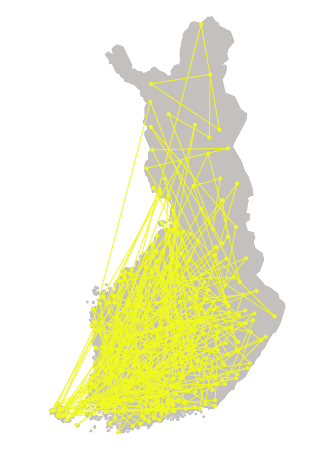

In [5]:
# To add the cities into a networkx Graph, we need list them as tuples:
# (city_index, Dictionary containing node info)
node_list = [] 
for ind, city in cities.iterrows():
    xy = np.asarray([city['x'], city['y']])
    node_list.append((ind, {'pos': xy}))


G = nx.Graph()
G.add_nodes_from(node_list)

# As an initial quess, let's connect the nodes according to their indexes:
G.add_edges_from([(n, (n + 1) % len(cities)) for n in range(len(cities))])

# Add usefull tracking info to the Graph
G.graph["length"] = get_length(G)
G.graph["N"] = len(cities)
G.graph["hash_grid"] = HashGrid(G)

# Let's save a copy of the original so we can reset the animation
G_original = copy.deepcopy(G)

fig, ax = plt.subplots(figsize=(8, 8))
plot_Graph(ax, G, 100, np.asarray([100, 0])) #100 hot color; 0 cold
plt.imshow(shiluette, extent=extent)
plt.show()

# Setup

In [6]:
""" Options For Visuals """
seed = 123
plot_realtime = False
track_best = False


""" Options For the Annealing process """
N_seg_max = 5  # How many points to permute at once.
kTs = np.linspace(start=G.graph['length'] / G.graph['N'], stop=500, num=1000)
#kTs = np. geomspace(start=G.graph['length'] / G.graph['N'], stop=500, num=2000)
N_walks = 10000 # per temperature

# Annealing

In [7]:
def update(i):
    global G_best
    ''' Annealing '''
    if i %  (len(kTs) / 10 ) == 0:
        print(f'At {100 * i // len(kTs)} %')
    kT = kTs[i]
    for walk in range(N_walks):
        # 1. Make a random change:
        N_seg = 1 + prng.binomial(N_seg_max - 1, 0.5)
        permutation = get_rnd_segment(G, N_seg, reach=2 * kT, prng=prng)
        # 2. Calculate the energy change
        dE = diff_E(G, *permutation)
        # 3. p("Accept change")=the Boltzmann's factor
        if prng.random() < np.exp(-1 * dE / kT):
            move_segment(G, *permutation)
            G.graph["length"] += dE
            if track_best and (G.graph["length"] <= G_best.graph["length"]):
                G_best = copy.deepcopy(G)
    
    ''' Plotting '''
    track_kT.append(kT)
    track_E.append(G.graph["length"] / 1000)
    plot_Graph(ax1, G, kT, kTs, N_walk=walk)
    ax1.imshow(shiluette, extent=extent)
    plot_log(ax2, track_kT=track_kT, track_E=track_E, kTs=kTs, N_cities=G.graph['N'])
    if plot_realtime:
        display(fig)
        clear_output(wait=True)
    
    

In [8]:
'''Embedded animation '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
anim = animation.FuncAnimation(
    fig, update, frames=len(kTs), interval=33
)
plt.close(fig)

In [ ]:
G, G_best, prng, track_kT, track_E = reset(G_original, G_original, seed)
rc("animation", html="jshtml") 
rc("animation", embed_limit = 2**128) # i.e. no limit
display(anim) 

In [ ]:
# Plot the best so far
fig, ax = plt.subplots(figsize=(8, 8))

plot_Graph(ax, G_best, kTs[-1], kTs)
plt.imshow(shiluette, extent=extent)
plt.show()


# Saving

In [9]:
# Save paths so that we can draw pretty posters using processing:
latest, best = (f"km_xs_{seed}seed_{N_walks}walks_{len(kTs)}kTs",
                f"km_xs_{seed}seed_{N_walks}walks_{len(kTs)}kTs")

#pickle.dump(path_to_list(G_best), open(path.join('.', 'data', f'{best}.p'), "wb" ), protocol=1)
#pickle.dump(path_to_list(G), open(path.join('.', 'data', f'{latest}.p'), "wb" ), protocol=1)
print("Saved routes as:")
print(best)
print(latest)

Saved routes as:
km_xs_123seed_10000walks_1000kTs
km_xs_123seed_10000walks_1000kTs


In [10]:
# Animation as mp4. Usefull tutorials
# https://www.wikihow.com/Install-FFmpeg-on-Windows
# https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
G, G_best, prng, track_kT, track_E = reset(G_original, G_original, seed)
rc("animation", ffmpeg_path = r'C:\\ffmpeg\\bin\\ffmpeg.exe')
writervideo = animation.FFMpegWriter(fps=30) 
anim.save(path.join('.', 'media', f"{latest}.mp4"), writer=writervideo)

At 0 %
At 0 %
At 10 %
At 20 %
At 30 %
At 40 %
At 50 %
At 60 %
At 70 %
At 80 %
At 90 %


In [11]:
# Save paths so that we can draw pretty posters using processing:
latest, best = (f"{int(G.graph['length']/1000)}km_{count_intersections(G)}xs_{seed}seed_{N_walks}walks_{len(kTs)}kTs",
                f"{int(G_best.graph['length']/1000)}km_{count_intersections(G_best)}xs_{seed}seed_{N_walks}walks_{len(kTs)}kTs")

pickle.dump(path_to_list(G_best), open(path.join('.', 'data', f'{best}.p'), "wb" ), protocol=1)
pickle.dump(path_to_list(G), open(path.join('.', 'data', f'{latest}.p'), "wb" ), protocol=1)
print("change the names:")
print(best)
print(latest)

change the names:
79163km_8166xs_123seed_10000walks_1000kTs
8677km_2xs_123seed_10000walks_1000kTs


In [ ]:
# Animation as a gif
G, G_best, prng, track_kT, track_E = reset(G_original, G_original, seed)
writergif = animation.PillowWriter(fps=30) 
anim.save(path.join('.', 'media', f"{latest}.gif"), writer=writergif)